In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.rcParams['figure.figsize'] = (6,6)
# mpl.rcParams['figure.dpi'] = 100
# mpl.rcParams["image.origin"] = 'lower'

In [2]:
config = {
    "base_dir":        "/eos/home-d/dmapelli/public/latino/",
    "plot_config":     "Full2018v6s5",
    "cut":             "res_sig_mjjincl",
    "model_version":   "v32",
    "model_tag":       "res_4depth_v0",
    "samples_version": "v10",
    "cols": ['mjj_vbs', 'vbs_0_pt', 'vbs_1_pt', 'deltaeta_vbs', 'deltaphi_vbs', 
          'vjet_0_pt', 'vjet_1_pt', 'vjet_0_eta', 'vjet_1_eta', 
         'Lepton_pt', 'Lepton_eta', 'Lepton_flavour', 
         ]
}

In [3]:
len(config["cols"])

12

```.python
"cut":             "boos_sig_mjjincl",
"cut":             "res_sig_mjjincl",

"model_tag":       "res_5depth_v0",

    "cols": ['mjj_vbs', 'deltaeta_vbs', 
            'mjj_vjet', 
            'Lepton_pt', 'Lepton_eta' ]
    "cols": ['mjj_vbs', 'vbs_0_pt', 'vbs_1_pt', 'deltaeta_vbs', 'deltaphi_vbs', 
          'mjj_vjet', 'vjet_0_pt', 'vjet_1_pt', 'vjet_0_eta', 'vjet_1_eta', 
         'Lepton_pt', 'Lepton_eta', 'Lepton_flavour', 
         ]
    "cols": ['mjj_vbs', 'vbs_0_pt', 'vbs_1_pt', 'deltaeta_vbs', 'deltaphi_vbs', 
          'mjj_vjet', 'vjet_0_pt', 'vjet_1_pt', 'vjet_0_eta', 'vjet_1_eta', 
         'Lepton_pt', 'Lepton_eta', 'Lepton_flavour', 
         'PuppiMET', 
         'Zvjets_0', 'Zlep', 
         'Asym_vbs', 'Asym_vjet', 'A_ww', 
         'Mtw_lep', 'w_lep_pt', 'Mww', 'R_ww', 'R_mw', 
         'Centr_vbs', 'Centr_ww'
         ]
 ```

In [4]:
import os

config_base_dir = os.path.join(config["base_dir"], config["plot_config"])

# create the model directory
model_dir   = os.path.join(config_base_dir, config["cut"] , "models",  config["model_version"])
os.makedirs(model_dir, exist_ok=True)

# load numpy
samples_dir = os.path.join(config_base_dir, config["cut"] , "samples", config["samples_version"])
import pickle
signal = pickle.load(open(os.path.join(samples_dir, "for_training/signal_balanced.pkl"),     "rb"))
bkg    = pickle.load(open(os.path.join(samples_dir, "for_training/background_balanced.pkl"), "rb"))

## Samples preparation for NN

In [5]:
## using 
## source /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/setup.sh
#!pip3 install --user imbalanced-learn==0.5

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from imblearn.keras import balanced_batch_generator
from imblearn.over_sampling import RandomOverSampler

Using TensorFlow backend.


In [7]:
## instead of reading the variables from file,
## we now set the variables here, and then dump them
# import yaml
# yaml_vars = yaml.safe_load(open(os.path.join(model_dir, "variables.yml")))
# print("yaml: ", type(yaml_vars), len(yaml_vars))
# cols = yaml_vars

In [8]:
X_sig = signal[config["cols"]].values
X_bkg = bkg[config["cols"]].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values
Wnn_sig = (signal["weight_"]).values
Wnn_bkg = (bkg["weight_"]).values

In [9]:
X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])
Wnn = np.hstack([Wnn_sig, Wnn_bkg])

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open(f"{model_dir}/scaler_model.pkl", "wb"))

In [11]:
# i = 2
# print(cols[i])
# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5), dpi=100)
# ax1.hist(X[:,i], bins=50)
# ax1.set_yscale("log")
# ax2.hist(X_scaled[:,i], weights=W, bins=50)
# plt.yscale("log")

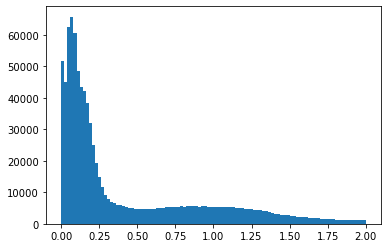

In [12]:
# _ = plt.hist(W, bins=100)
_ = plt.hist(W, bins=100, range=(0,2))

##  Balancing


In [13]:
config["test_size"] = 0.2
#config["val_size"]  = 0.5  ## test != val
config["val_size"]  = 0.0  ## test == val

X_train, X_temp, y_train, y_temp, W_train, W_temp , Wnn_train, Wnn_temp = train_test_split(X_scaled, Y,  W, Wnn, test_size=config["test_size"])
#X_val,   X_test, y_val,   y_test, W_val,   W_test = train_test_split(X_temp,   y_temp, W_temp, test_size=config["val_size"]) ## test != val

In [14]:
print("Training   dataset: ", X_train.shape)
print("Test + Val dataset: ", X_temp.shape)
#print("Testing    dataset: ", X_test.shape)
#print("Validation dataset: ", X_val.shape)

Training   dataset:  (847011, 12)
Test + Val dataset:  (211753, 12)


Create generators to balance signal and background

In [15]:
config["batch_size"] = 1024

training_generator,   steps_per_epoch_train = balanced_batch_generator(X_train, y_train, W_train, batch_size=config["batch_size"], sampler=RandomOverSampler())
#validation_generator, steps_per_epoch_val   = balanced_batch_generator(X_val,   y_val,   W_val,   batch_size=config["batch_size"], sampler=RandomOverSampler()) ## test != val
validation_generator, steps_per_epoch_val   = balanced_batch_generator(X_temp,  y_temp,  W_temp,   batch_size=config["batch_size"], sampler=RandomOverSampler()) ## test == val

## SKLEARN - AVOVA F-Test

In [16]:
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, f_classif

import itertools

## This uses only public API, but is a real mess
#mask = [False for i in range (len(config["cols"]))]
#for varn  in range (len(config["cols"]) + 1):
#    a = SelectKBest(f_classif, k=varn)
#    a.fit(X_train, y_train)
#    mask_old = mask.copy()
#    mask = a.get_support()
#    mask_xor = [x ^ y for x,y in zip(mask, mask_old)]
#    print(varn, list(itertools.compress( config["cols"], mask_xor )))
        
## This uses a SelectKBest "private" member, but is faster and cleaner
selection = SelectKBest(f_classif, k=10)
selection.fit(X_train, y_train)
scores_df = pd.DataFrame({"score": selection.scores_, "varname": config["cols"]})


In [17]:
## visualize list of scores
#scores_df.sort_values(by=["score"], ascending=False)

<BarContainer object of 12 artists>

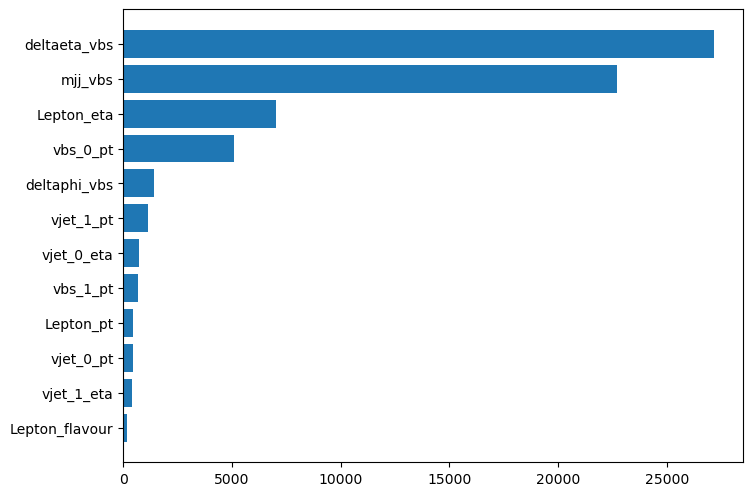

In [18]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')

## visualize scores as barchart
s_df = scores_df.sort_values(by=["score"], ascending=True)
plt.barh(range(len(s_df["score"])), s_df["score"], tick_label=s_df["varname"])

## Keras model

In [19]:
from keras.models import load_model

model = load_model(os.path.join(model_dir, "model.h5"))

model.summary()

W0303 15:22:31.755095 140646883383104 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0303 15:22:31.816567 140646883383104 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0303 15:22:32.020939 140646883383104 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0303 15:22:32.023103 140646883383104 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                650       
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 80)                4080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 80)                320       
_________________________________________________________________
activation_2 (Activation)    (None, 80)                0         
__________

# SHAP

In [20]:
## https://github.com/slundberg/shap

# !pip3 install --user shap

In [21]:
import shap

shap.initjs()

In [ ]:
index1 = [x for x in range(len(X_train))]
X_train_pd = pd.DataFrame(X_train, index=index1, columns=config["cols"])
index2 = [x for x in range(len(X_train), len(X_train) + len(X_temp))]
X_temp_pd = pd.DataFrame(X_temp, index=index2, columns=config["cols"])

shap_lenght = 200

# explain predictions of the model on three images
#e = shap.DeepExplainer(model, X_train_pd.iloc[0,:])
e = shap.KernelExplainer(model.predict, X_train_pd.iloc[:shap_lenght,:])
shap_values = e.shap_values(X_temp[:shap_lenght])


W0303 15:22:47.039830 140646883383104 kernel.py:108] Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


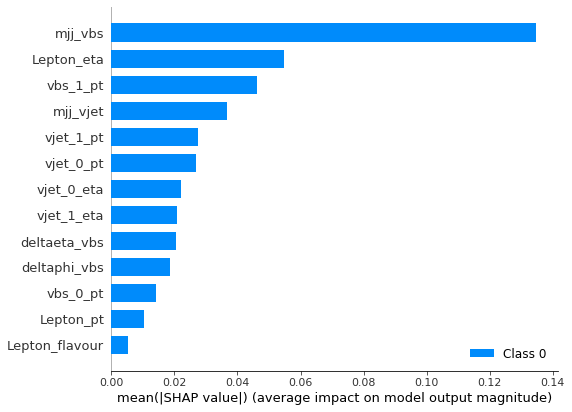

In [32]:
shap.summary_plot(shap_values, X_temp_pd.iloc[:shap_lenght,:], plot_type="bar")

In [40]:
index_event = 150
shap.force_plot(e.expected_value[0], shap_values[0][index_event], X_temp_pd.iloc[index_event,:])

In [36]:
shap.force_plot(e.expected_value, shap_values[0], X_temp_pd.iloc[:shap_lenght,:])

# Evaluation

In [ ]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve

pred_test  = model.predict(X_test,  batch_size=2048)
pred_train = model.predict(X_train, batch_size=2048)
auc_w_test  = roc_auc_score(y_test, pred_test,  sample_weight=W_test)
auc_w_train = roc_auc_score(y_train,pred_train, sample_weight=W_train)
fpW_test,  tpW_test,  thW_test  = roc_curve(y_test,  pred_test , sample_weight=W_test)
fpW_train, tpW_train, thW_train = roc_curve(y_train, pred_train, sample_weight=W_train)
#print("AUC score: " + str(auc))

fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

# ax1.plot(fp, tp, label=f"ROC (AUC={auc:.3f})", color="blue")
ax1.plot(fpW_test,  tpW_test,  label=f"ROC test  (AUC={auc_w_test:.3f})", color="red")
ax1.plot(fpW_train, tpW_train, label=f"ROC train (AUC={auc_w_train:.3f})", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18)

#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large")

ax1.grid()

ax1.legend(loc=(0.4, 0.5), fontsize="large")

fig.tight_layout()

In [107]:
#r = model.evaluate_generator(training_generator, steps=1000)
#r = model.evaluate_generator(validation_generator, steps=1000)


In [108]:
#print(model.metrics_names, r)

In [ ]:
fig, ax = plt.subplots(figsize=(7,6), dpi=100)
ax.plot(history.epoch, history.history["val_loss"], label="validation loss")
ax.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

In [ ]:
results_test  = model.predict(X_test, batch_size=2048)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(results_test[y_test==0],weights=W_test[y_test==0], bins=25, density=True, label="false test", histtype="step")
plt.hist(results_test[y_test==1],weights=W_test[y_test==1], bins=25, density=True, label="true test", histtype="step")
results_train = model.predict(X_train, batch_size=2048)
plt.hist(results_train[y_train==0],weights=W_train[y_train==0], bins=25, density=True, label="false train", histtype="step")
plt.hist(results_train[y_train==1],weights=W_train[y_train==1], bins=25, density=True, label="true train", histtype="step")
#plt.yscale("log")
plt.legend()

# 
# 

#results_train[y_train==1]
rtest  = [x[0] for x in results_test[y_test==1]]
rtrain = [x[0] for x in results_train[y_train==1]]

from scipy import stats
stats.ks_2samp(rtrain, rtest)

## Evaluation by sample

In [57]:
bkg["y"] = model.predict(scaler.transform(bkg[config["cols"]].values), batch_size=2048)

In [58]:
signal["y"] = model.predict(scaler.transform(signal[config["cols"]].values), batch_size=2048)

In [59]:
wjets = bkg[bkg["sample_name"] == "Wjets"]
top = bkg[bkg["sample_name"] == "top"]
dy = bkg[bkg["sample_name"] == "DY"]

In [ ]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(bkg[bkg["sample_name"] == "Wjets"]["y"], bins=50, density=True, label="W+jets", histtype="step")
plt.hist(bkg[bkg["sample_name"] == "top"]["y"],   bins=50, density=True, label="top",    histtype="step")
plt.hist(bkg[bkg["sample_name"] == "DY"]["y"],    bins=50, density=True, label="DY",     histtype="step")

plt.hist(signal["y"], bins=50,density=True, label="signal", histtype="step")
#plt.yscale("log")
plt.legend()

In [ ]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(wjets["y"], weights=wjets.weight_norm, bins=50, density=True, label="W+jets", histtype="step")
plt.hist(top["y"],   weights=top.weight_norm,  bins=50, density=True, label="top",    histtype="step")
plt.hist(dy["y"],    weights=dy.weight_norm,  bins=50, density=True, label="DY",     histtype="step")

plt.hist(signal["y"], weights=signal.weight_norm, bins=50,density=True, label="signal", histtype="step")
#plt.yscale("log")
plt.legend()

In [ ]:
## some useful snippets

## callbacks
# auto_save = ModelCheckpoint("../models/model12_balanced_100_50.hd5", monitor='val_loss', 
#                     verbose=1, save_best_only=True, save_weights_only=False, 
#                     mode='auto', period=5)
#
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, 
#                             patience=10, verbose=1)






## In case you do not want to use the generators
# history = model.fit(
#             X_train,y_train, 
#             sample_weight=W_train, 
#             epochs=50,
#             validation_data = (X_val, y_val, W_val),
#             batch_size=1024,
#             shuffle=True 
#             )